In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

import torch
import torch.nn as nn

In [60]:
import sys
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader/utility')
sys.path.insert(1, '/home/krystian/Repos/XTB-Trader')
from XTBClient.api import XTBClient, PERIOD
import utility 

def get_data_for_symbol(symbol):
    c = XTBClient()
    c.login(os.environ.get("XTB_user_num"), os.environ.get("XTB_pass"))
    df = c.get_candles_in_range(symbol, PERIOD.FIVE_MINUTES.value, start=datetime.now() - timedelta(days=150))
    c.logout()
    
    df = df.reset_index()
    df.rename(columns={"timestamp": "date"}, inplace=True)
    
    df['date'] = df['date'].apply(pd.to_datetime)
    df.set_index('date',inplace=True)
    return df

In [61]:
df = get_data_for_symbol("EURUSD")
df

,open,close,high,low,volume
date,,,,,
2023-05-23 22:00:00,1.07716,1.07724,1.07730,1.07716,227.0
2023-05-23 22:05:00,1.07724,1.07710,1.07724,1.07700,193.0
2023-05-23 22:10:00,1.07710,1.07706,1.07711,1.07701,407.0
2023-05-23 22:15:00,1.07707,1.07707,1.07714,1.07704,416.0
2023-05-23 22:20:00,1.07708,1.07708,1.07712,1.07706,374.0
...,...,...,...,...,...
2023-06-27 14:00:00,1.09653,1.09577,1.09679,1.09536,7943.0
2023-06-27 14:05:00,1.09579,1.09557,1.09583,1.09511,7709.0
2023-06-27 14:10:00,1.09560,1.09440,1.09560,1.09418,7229.0


In [62]:
closed_prices = df["close"]

In [63]:
seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [64]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

In [65]:
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [66]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [67]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
   

In [68]:
model = Model(1 , 64)


optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [69]:
num_epochs = 100
for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.09183607
20 epoch loss 0.04068584
30 epoch loss 0.03165636
40 epoch loss 0.027026616
50 epoch loss 0.019056033
60 epoch loss 0.0073046708
70 epoch loss 0.0017976039
80 epoch loss 0.0022091866
90 epoch loss 0.0013521808


In [70]:
model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
index = df[int(0.8*len(df)+3):].index

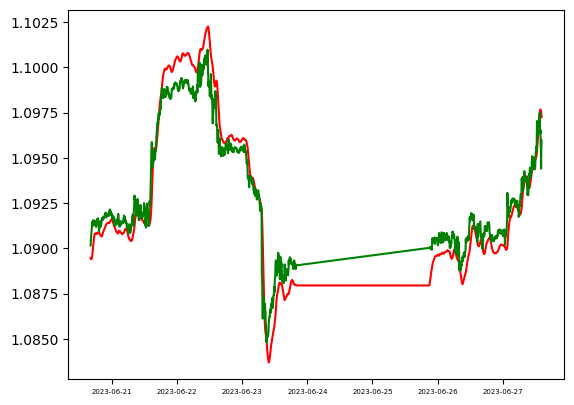

In [71]:
plt.plot(index, pred.squeeze() , color = "red" , label = "predicted")
plt.plot(index, real.squeeze() , color = "green" , label = "real")
plt.xticks(fontsize=5)
plt.show()